In [12]:
from torchvision import transforms
from torch.utils.data import DataLoader
import torch

from tqdm.auto import tqdm
from os.path import splitext

from utils.unet import UNet
from utils.dataset import FreiHANDDataset
from utils.utils import DiceLoss, plot_losses, plot_heatmaps

In [13]:
LOAD_ON = False
TRAIN_ON = False

In [14]:
import requests
import zipfile

if LOAD_ON:
    url = 'https://lmb.informatik.uni-freiburg.de/data/freihand/FreiHAND_pub_v2.zip'
    filename = 'FreiHAND_pub_v2.zip'

    response = requests.get(url, stream=True)
    with open(filename, 'wb') as f:
        f.write(response.content)

    print(f'{filename} downloaded!')

    with zipfile.ZipFile(filename, 'r') as zip_ref:
        zip_ref.extractall('FreiHAND_dataset')

    print("File unzipped successfully!")

In [15]:
import os

print(len(os.listdir(os.path.join('FreiHAND_dataset/training', 'rgb'))))

130240


In [16]:
KEYPOINTS_NUM = 21
RESIZED_IMG_SIZE = 128
MEANS = [0.3950, 0.4323, 0.2954]
STDS = [0.1966, 0.1734, 0.1836]

In [17]:
IMAGE_DIR = 'FreiHAND_dataset/training'
MODEL_PATH = 'model/m_keypoints.pth'

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(DEVICE)

BATCH_SIZE = 48
EPOCH_NUM = 100
TRAIN_RATIO = 0.8

cuda


# Training

In [18]:
def train():
    model = UNet(KEYPOINTS_NUM).to(DEVICE)
    model.load_state_dict(torch.load(MODEL_PATH))

    dataset = FreiHANDDataset(IMAGE_DIR, transform=transforms.Compose([
        transforms.Resize((RESIZED_IMG_SIZE, RESIZED_IMG_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize(mean=MEANS, std=STDS)
    ]))
    train_dataset, test_dataset = torch.utils.data.random_split(dataset, [0.8, 0.2])
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, num_workers=2, shuffle=True, drop_last=True, persistent_workers=True)
    val_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, num_workers=2, shuffle=True, drop_last=True, persistent_workers=True)

    params = [p for p in model.parameters() if p.requires_grad]
    optimizer = torch.optim.SGD(params, lr=0.1)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer, factor=0.1)

    dice_loss = DiceLoss()

    tr_losses, val_losses = [], []

    for epoch in range(EPOCH_NUM):
        epoch_loss = 0
        prog_bar_train = tqdm(train_loader, total=50)

        model.train()
        for i, batch in enumerate(prog_bar_train):
            if i >= 50:
                break
            images, targets = batch

            images = images.to(DEVICE)
            gt_heatmaps = targets['heatmaps'].to(DEVICE)

            optimizer.zero_grad()
            heatmaps = model(images)
            loss = dice_loss(heatmaps, gt_heatmaps)
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()
            prog_bar_train.set_description(desc=f"Loss: {loss.item():.4f}")

        val_loss = 0
        prog_bar_val = tqdm(val_loader, total=20)

        model.eval()
        with torch.no_grad():
            for i, batch in enumerate(prog_bar_val):
                if i >= 20:
                    break
                images, targets = batch

                images = images.to(DEVICE)
                gt_heatmaps = targets['heatmaps'].to(DEVICE)

                heatmaps = model(images)
                loss = dice_loss(heatmaps, gt_heatmaps)

                val_loss += loss.item()
                prog_bar_val.set_description(desc=f"ValLoss: {loss.item():.4f}")

        train_loss = epoch_loss / 50
        val_loss = val_loss / 20
        print(f"Epoch {epoch+1}, Train Loss: {train_loss}, Validation Loss: {val_loss}")

        tr_losses.append(train_loss)
        val_losses.append(val_loss)

        scheduler.step(train_loss)

        if epoch != 0 and epoch % 5 == 0:
            torch.save(model.state_dict(), splitext(MODEL_PATH)[0] + '_' + str(epoch+1) + '.pth')

    torch.save(model.state_dict(), MODEL_PATH)
    plot_losses(tr_losses, val_losses, 'Losses.png')

C:\Users\sveta\AppData\Local\Temp\ipykernel_11520\1106800027.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(MODEL_PATH))


  0%|          | 0/50 [00:09<?, ?it/s]

  0%|          | 0/20 [00:08<?, ?it/s]

Epoch 1, Train Loss: 0.4726001799106598, Validation Loss: 0.4581671357154846


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2, Train Loss: 0.43364959478378295, Validation Loss: 0.43878015875816345


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3, Train Loss: 0.42566961407661436, Validation Loss: 0.43311247825622556


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4, Train Loss: 0.4164097309112549, Validation Loss: 0.4463271528482437


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 5, Train Loss: 0.4168858206272125, Validation Loss: 0.4309681594371796


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 6, Train Loss: 0.4018613648414612, Validation Loss: 0.4561879575252533


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 7, Train Loss: 0.3933730137348175, Validation Loss: 0.40638734996318815


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 8, Train Loss: 0.39146266102790833, Validation Loss: 0.4126363813877106


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 9, Train Loss: 0.3873838996887207, Validation Loss: 0.40775051414966584


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 10, Train Loss: 0.3873507797718048, Validation Loss: 0.4139563798904419


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 11, Train Loss: 0.3842296099662781, Validation Loss: 0.3845706135034561


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 12, Train Loss: 0.3753823506832123, Validation Loss: 0.4094147741794586


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 13, Train Loss: 0.379760810136795, Validation Loss: 0.37768597304821017


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 14, Train Loss: 0.3713353335857391, Validation Loss: 0.3715423732995987


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 15, Train Loss: 0.372062087059021, Validation Loss: 0.39291487336158754


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 16, Train Loss: 0.3669199764728546, Validation Loss: 0.3809255748987198


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 17, Train Loss: 0.36011118173599244, Validation Loss: 0.37905077934265136


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 18, Train Loss: 0.35929021120071414, Validation Loss: 0.39768196940422057


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 19, Train Loss: 0.36261919379234314, Validation Loss: 0.3784782916307449


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 20, Train Loss: 0.36388890743255614, Validation Loss: 0.3732806533575058


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 21, Train Loss: 0.3573383665084839, Validation Loss: 0.3741327315568924


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 22, Train Loss: 0.3553983676433563, Validation Loss: 0.374564191699028


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 23, Train Loss: 0.35056679010391234, Validation Loss: 0.36803224980831145


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 24, Train Loss: 0.35389822483062744, Validation Loss: 0.37991292476654054


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 25, Train Loss: 0.356114399433136, Validation Loss: 0.35803190171718596


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 26, Train Loss: 0.3506982469558716, Validation Loss: 0.3944144666194916


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 27, Train Loss: 0.3469992816448212, Validation Loss: 0.36570867598056794


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 28, Train Loss: 0.34429225206375125, Validation Loss: 0.3542484313249588


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 29, Train Loss: 0.34544124007225036, Validation Loss: 0.3582643359899521


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 30, Train Loss: 0.33625938892364504, Validation Loss: 0.3503899574279785


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 31, Train Loss: 0.3511442768573761, Validation Loss: 0.34219445288181305


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 32, Train Loss: 0.33820597887039183, Validation Loss: 0.3494507849216461


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 33, Train Loss: 0.3414152693748474, Validation Loss: 0.3595358312129974


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 34, Train Loss: 0.3364304935932159, Validation Loss: 0.34568904936313627


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 35, Train Loss: 0.33696075081825255, Validation Loss: 0.33865614235401154


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 36, Train Loss: 0.33337501525878904, Validation Loss: 0.34952532649040224


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 37, Train Loss: 0.332015198469162, Validation Loss: 0.357106813788414


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 38, Train Loss: 0.328605614900589, Validation Loss: 0.34910463988780976


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 39, Train Loss: 0.3374223291873932, Validation Loss: 0.3428642988204956


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 40, Train Loss: 0.3307320201396942, Validation Loss: 0.3547685623168945


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 41, Train Loss: 0.32693599224090575, Validation Loss: 0.33896271586418153


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 42, Train Loss: 0.3296366584300995, Validation Loss: 0.3323136746883392


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 43, Train Loss: 0.33236286520957947, Validation Loss: 0.3290423035621643


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 44, Train Loss: 0.3227213311195374, Validation Loss: 0.33638372719287873


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 45, Train Loss: 0.3206372785568237, Validation Loss: 0.336855885386467


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 46, Train Loss: 0.31840389251708984, Validation Loss: 0.34002947211265566


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 47, Train Loss: 0.31983248829841615, Validation Loss: 0.33387188613414764


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 48, Train Loss: 0.32732101321220397, Validation Loss: 0.32484856247901917


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 49, Train Loss: 0.3229953896999359, Validation Loss: 0.33862648010253904


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 50, Train Loss: 0.32109524846076964, Validation Loss: 0.3339168816804886


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 51, Train Loss: 0.318910311460495, Validation Loss: 0.33546917140483856


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 52, Train Loss: 0.3192188251018524, Validation Loss: 0.3306830197572708


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 53, Train Loss: 0.32117594599723814, Validation Loss: 0.33139210045337675


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 54, Train Loss: 0.31841025114059446, Validation Loss: 0.3328445374965668


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 55, Train Loss: 0.31740015625953677, Validation Loss: 0.32609266936779024


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 56, Train Loss: 0.3159806001186371, Validation Loss: 0.3392330229282379


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 57, Train Loss: 0.3166049933433533, Validation Loss: 0.33002219498157503


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 58, Train Loss: 0.3139984107017517, Validation Loss: 0.33567415475845336


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 59, Train Loss: 0.31117298841476443, Validation Loss: 0.336576846241951


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 60, Train Loss: 0.3158798813819885, Validation Loss: 0.3256440579891205


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 61, Train Loss: 0.3121767270565033, Validation Loss: 0.3259277492761612


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 62, Train Loss: 0.3065081310272217, Validation Loss: 0.3289415240287781


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 63, Train Loss: 0.3125041174888611, Validation Loss: 0.32712189555168153


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 64, Train Loss: 0.3123662531375885, Validation Loss: 0.3327749878168106


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 65, Train Loss: 0.31105412006378175, Validation Loss: 0.31547823548316956


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 66, Train Loss: 0.3058085095882416, Validation Loss: 0.3206175804138184


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 67, Train Loss: 0.30576945304870606, Validation Loss: 0.3294419527053833


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 68, Train Loss: 0.29917951464653014, Validation Loss: 0.3156116038560867


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 69, Train Loss: 0.306662392616272, Validation Loss: 0.3190219223499298


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 70, Train Loss: 0.30212364554405213, Validation Loss: 0.3045014560222626


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 71, Train Loss: 0.29995518922805786, Validation Loss: 0.31622715294361115


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 72, Train Loss: 0.29908583998680116, Validation Loss: 0.31914193034172056


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 73, Train Loss: 0.2995643103122711, Validation Loss: 0.3180756509304047


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 74, Train Loss: 0.30566965460777284, Validation Loss: 0.3125631302595139


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 75, Train Loss: 0.3037955665588379, Validation Loss: 0.31841221153736116


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 76, Train Loss: 0.3028108620643616, Validation Loss: 0.3271554112434387


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 77, Train Loss: 0.2987092339992523, Validation Loss: 0.3194621205329895


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 78, Train Loss: 0.2964803540706635, Validation Loss: 0.31788161098957063


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 79, Train Loss: 0.2887103033065796, Validation Loss: 0.3018889456987381


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 80, Train Loss: 0.2942114996910095, Validation Loss: 0.30867142975330353


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 81, Train Loss: 0.2937668263912201, Validation Loss: 0.31708686947822573


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 82, Train Loss: 0.2950855767726898, Validation Loss: 0.3127857089042664


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 83, Train Loss: 0.29433921098709104, Validation Loss: 0.320877343416214


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 84, Train Loss: 0.29388856887817383, Validation Loss: 0.30928754806518555


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 85, Train Loss: 0.29416191697120664, Validation Loss: 0.3059161514043808


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 86, Train Loss: 0.28772175312042236, Validation Loss: 0.31149410605430605


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 87, Train Loss: 0.28744165778160097, Validation Loss: 0.30641288459300997


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 88, Train Loss: 0.28224060535430906, Validation Loss: 0.30024058520793917


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 89, Train Loss: 0.2889795911312103, Validation Loss: 0.3105038970708847


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 90, Train Loss: 0.289358149766922, Validation Loss: 0.2990973472595215


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 91, Train Loss: 0.2854436671733856, Validation Loss: 0.3022543728351593


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 92, Train Loss: 0.2892305827140808, Validation Loss: 0.3012835204601288


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 93, Train Loss: 0.28420645713806153, Validation Loss: 0.3177128940820694


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 94, Train Loss: 0.28549806237220765, Validation Loss: 0.30440679788589475


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 95, Train Loss: 0.28718292713165283, Validation Loss: 0.2975143641233444


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 96, Train Loss: 0.2890907621383667, Validation Loss: 0.3009278833866119


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 97, Train Loss: 0.2832986080646515, Validation Loss: 0.3024223864078522


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 98, Train Loss: 0.28264801383018495, Validation Loss: 0.30029840767383575


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 99, Train Loss: 0.2888670802116394, Validation Loss: 0.2969378143548965


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 100, Train Loss: 0.2696646368503571, Validation Loss: 0.28715998530387876


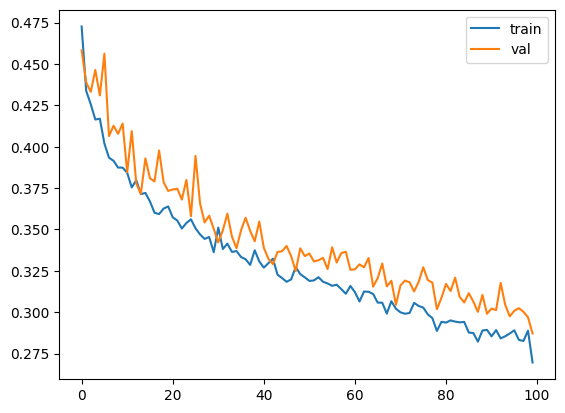

In [19]:
if TRAIN_ON:
    train()

# Evaluation

In [20]:
import math
import matplotlib.pyplot as plt
import numpy as np


def plot_results(targets, heatmaps, resized_img_size, filename):
    pred_keypoints = torch.argmax(torch.flatten(heatmaps, start_dim=2), dim=2)
    # find exact location
    pred_keypoints_y = pred_keypoints.float() // resized_img_size
    pred_keypoints_x = pred_keypoints.float() - resized_img_size * pred_keypoints_y

    # normalize positions
    pred_keypoints_x /= resized_img_size
    pred_keypoints_y /= resized_img_size

    num_images = len(heatmaps)
    _, axes = plt.subplots(math.ceil(num_images / 5), 5, figsize=(15, 10))
    axes = list(axes)
    for i in range(num_images):
        img_size = np.array(targets['img_size'])[:, i]
        img_org = targets['original'][i]

        image = np.array(img_org)
        image = image.transpose((1, 2, 0))

        keypoints_x = pred_keypoints_x[i] * img_size[0]
        keypoints_y = pred_keypoints_y[i] * img_size[1]

        axes[i // 5][i % 5].imshow(image)
        axes[i // 5][i % 5].scatter(keypoints_x.int(), keypoints_y.int(), s=10, marker='.', c='r')
        axes[i // 5][i % 5].axis('off')
    plt.tight_layout()
    plt.savefig('figures/' + filename)

In [21]:
model = UNet(KEYPOINTS_NUM).to(DEVICE)
model.load_state_dict(torch.load(MODEL_PATH))
model.eval()

dataset = FreiHANDDataset(IMAGE_DIR, transform=transforms.Compose([
    transforms.Resize((RESIZED_IMG_SIZE, RESIZED_IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=MEANS, std=STDS)
]))

loader = DataLoader(dataset, batch_size=15, num_workers=2, shuffle=True)

C:\Users\sveta\AppData\Local\Temp\ipykernel_11520\3689076526.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(MODEL_PATH))


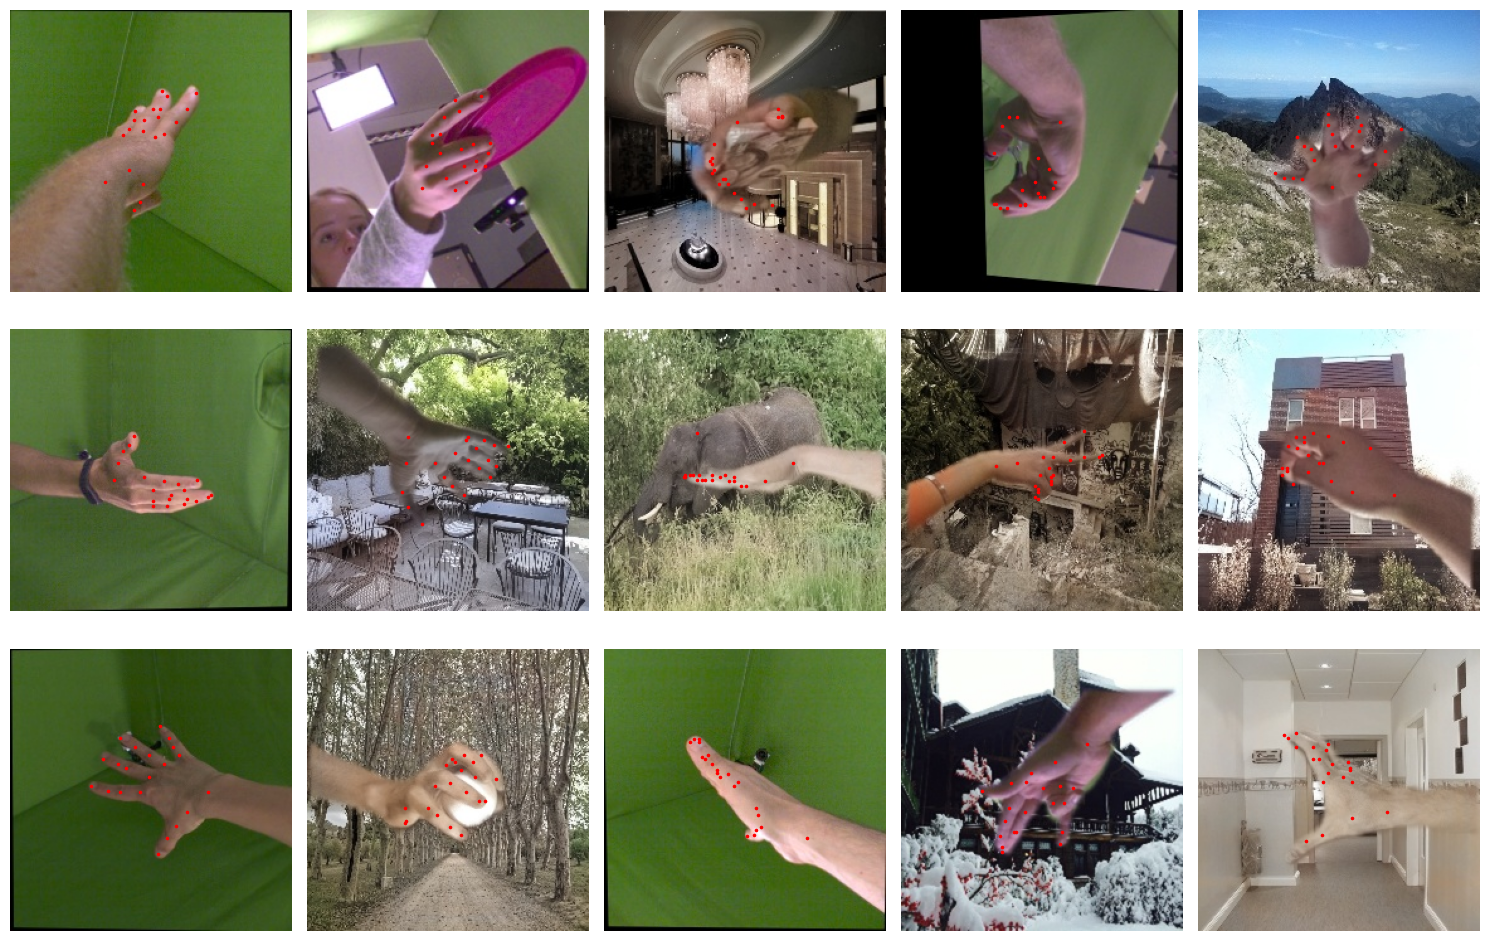

In [22]:
with torch.no_grad():
    for i, batch in enumerate(loader):
        images, targets = batch
        images = images.to(DEVICE)

        heatmaps = model(images).cpu()
        # plot_heatmaps(heatmaps[0], 'Result_Heatmap.png')
        plot_results(targets, heatmaps, RESIZED_IMG_SIZE, 'Results.png')
        break
